In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import trange
from tqdm import tqdm

# Setting Constants
x_0 = 0
y_0 = 0
t_i = 0
t_f = 8

mass = 1
steps = 150  # Reduced from 800 - fewer points to update
numb_paths = 1000

times = np.linspace(t_i, t_f, steps)
dt = times[1] - times[0]

# Position generating function
def Pos_Gen(x0, xN, Steps, dt):
    path = np.zeros(Steps)
    path[0] = x0

    for i in range(1, Steps):
        path[i] = path[i-1] + np.random.normal(0, np.sqrt(dt))

    # shift so endpoint is exactly xN
    path += np.linspace(0, xN - path[-1], Steps)
    return path

# Vectorized interior point update
def metropolis_path_update_vectorised(paths, times, mass, potential, i, sigma_prop):
    dt = times[1] - times[0]

    x_old = paths[:, i]
    x_prev = paths[:, i - 1]
    x_next = paths[:, i + 1]

    x_new = x_old + np.random.normal(0, sigma_prop, size=x_old.shape)

    # Kinetic term change
    dS_kin = (mass / (2*dt)) * (
        (x_new - x_prev)**2 + (x_next - x_new)**2
        - (x_old - x_prev)**2 - (x_next - x_old)**2
    )

    # Potential term change
    x_mid_prev_old = 0.5 * (x_prev + x_old)
    x_mid_next_old = 0.5 * (x_old + x_next)
    x_mid_prev_new = 0.5 * (x_prev + x_new)
    x_mid_next_new = 0.5 * (x_new + x_next)

    dS_pot = dt * (
        potential(x_mid_prev_new) + potential(x_mid_next_new)
        - potential(x_mid_prev_old) - potential(x_mid_next_old)
    )

    dS = dS_kin + dS_pot

    accept = np.random.rand(len(x_old)) < np.exp(-dS)
    paths[accept, i] = x_new[accept]

    return np.mean(accept)

# NEW: Endpoint update function
def metropolis_endpoint_update_vectorised(paths, times, mass, potential, sigma_prop):
    """
    Vectorised Metropolis update for endpoint (last point) of all paths.
    """
    dt = times[1] - times[0]
    i = paths.shape[1] - 1  # last point

    x_old = paths[:, i]
    x_prev = paths[:, i-1]

    # symmetric proposal
    x_new = x_old + np.random.normal(0, sigma_prop, size=x_old.shape)

    # Kinetic term change (only one neighbor)
    dS_kin = (mass / (2*dt)) * ((x_new - x_prev)**2 - (x_old - x_prev)**2)

    # Potential at midpoint between second-to-last and endpoint
    x_mid_old = 0.5 * (x_prev + x_old)
    x_mid_new = 0.5 * (x_prev + x_new)
    dS_pot_mid = dt * (potential(x_mid_new) - potential(x_mid_old))

    # CRITICAL FIX: Also include potential at the endpoint itself (half weight)
    dS_pot_end = 0.5 * dt * (potential(x_new) - potential(x_old))

    dS = dS_kin + dS_pot_mid + dS_pot_end

    accept = np.random.rand(len(x_old)) < np.exp(-dS)
    paths[accept, i] = x_new[accept]

    return np.mean(accept)

# Full sweep function - BETTER optimization
def metropolis_sweep_vectorised(paths, times, mass, potential, sigma_prop, n_interior_updates=5):
    """
    Do a partial sweep: update only n_interior_updates random interior points
    plus always update the endpoint.
    """
    n_steps = paths.shape[1]

    # Randomly select which interior points to update
    interior_indices = np.random.choice(range(1, n_steps-1), size=n_interior_updates, replace=False)

    acceptances = []
    for i in interior_indices:
        acc = metropolis_path_update_vectorised(paths, times, mass, potential, i, sigma_prop)
        acceptances.append(acc)

    # Always update endpoint
    endpoint_accept = metropolis_endpoint_update_vectorised(
        paths, times, mass, potential, sigma_prop
    )

    return np.mean(acceptances) if acceptances else 0.0, endpoint_accept

C:\Users\User\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Potentials

In [2]:
# Potential
def x_potential(x):
    return 1/2 * x**2

def y_potential(x):
    return 1000 * x**4

# X-Dimension Sampling

Thermalizing...


Thermalising:  28%|██▊       | 139/500 [00:00<00:00, 761.11it/s]

Endpoint acceptance ≈ 0.418
Endpoint acceptance ≈ 0.436


Thermalising:  70%|███████   | 350/500 [00:00<00:00, 773.18it/s]

Endpoint acceptance ≈ 0.414
Endpoint acceptance ≈ 0.416


Thermalising: 100%|██████████| 500/500 [00:00<00:00, 733.94it/s]


Endpoint acceptance ≈ 0.445

Sampling...


Sampling:   1%|          | 50/5000 [00:00<00:06, 794.34it/s]

Endpoint acceptance ≈ 0.431


Sampling:   3%|▎         | 154/5000 [00:00<00:06, 703.17it/s]

Endpoint acceptance ≈ 0.429


Sampling:   5%|▌         | 252/5000 [00:00<00:06, 772.03it/s]

Endpoint acceptance ≈ 0.449


Sampling:   7%|▋         | 350/5000 [00:00<00:06, 726.55it/s]

Endpoint acceptance ≈ 0.443


Sampling:   9%|▉         | 443/5000 [00:00<00:07, 587.04it/s]

Endpoint acceptance ≈ 0.427


Sampling:  11%|█         | 543/5000 [00:00<00:05, 777.86it/s]

Endpoint acceptance ≈ 0.424


Sampling:  13%|█▎        | 649/5000 [00:00<00:05, 765.19it/s]

Endpoint acceptance ≈ 0.449


Sampling:  15%|█▌        | 750/5000 [00:01<00:05, 741.41it/s]

Endpoint acceptance ≈ 0.422


Sampling:  17%|█▋        | 852/5000 [00:01<00:05, 822.03it/s]

Endpoint acceptance ≈ 0.428


Sampling:  19%|█▉        | 951/5000 [00:01<00:05, 730.82it/s]

Endpoint acceptance ≈ 0.436


Sampling:  21%|██        | 1051/5000 [00:01<00:05, 763.05it/s]

Endpoint acceptance ≈ 0.449


Sampling:  23%|██▎       | 1146/5000 [00:01<00:05, 720.92it/s]

Endpoint acceptance ≈ 0.424


Sampling:  25%|██▍       | 1241/5000 [00:01<00:05, 727.20it/s]

Endpoint acceptance ≈ 0.425


Sampling:  27%|██▋       | 1339/5000 [00:01<00:05, 704.16it/s]

Endpoint acceptance ≈ 0.446


Sampling:  29%|██▉       | 1442/5000 [00:01<00:05, 690.94it/s]

Endpoint acceptance ≈ 0.451


Sampling:  31%|███       | 1541/5000 [00:02<00:04, 695.04it/s]

Endpoint acceptance ≈ 0.418


Sampling:  33%|███▎      | 1644/5000 [00:02<00:04, 761.36it/s]

Endpoint acceptance ≈ 0.408


Sampling:  35%|███▍      | 1745/5000 [00:02<00:04, 688.77it/s]

Endpoint acceptance ≈ 0.416


Sampling:  37%|███▋      | 1842/5000 [00:02<00:04, 720.35it/s]

Endpoint acceptance ≈ 0.415


Sampling:  39%|███▉      | 1947/5000 [00:02<00:04, 755.10it/s]

Endpoint acceptance ≈ 0.445


Sampling:  41%|████      | 2053/5000 [00:02<00:03, 739.82it/s]

Endpoint acceptance ≈ 0.435


Sampling:  43%|████▎     | 2154/5000 [00:02<00:03, 787.73it/s]

Endpoint acceptance ≈ 0.400


Sampling:  45%|████▌     | 2252/5000 [00:03<00:04, 586.96it/s]

Endpoint acceptance ≈ 0.441


Sampling:  47%|████▋     | 2336/5000 [00:03<00:04, 634.29it/s]

Endpoint acceptance ≈ 0.398


Sampling:  49%|████▊     | 2436/5000 [00:03<00:03, 671.41it/s]

Endpoint acceptance ≈ 0.434


Sampling:  51%|█████     | 2533/5000 [00:03<00:03, 676.07it/s]

Endpoint acceptance ≈ 0.438


Sampling:  53%|█████▎    | 2644/5000 [00:03<00:03, 784.59it/s]

Endpoint acceptance ≈ 0.442


Sampling:  55%|█████▌    | 2751/5000 [00:03<00:02, 767.86it/s]

Endpoint acceptance ≈ 0.427


Sampling:  57%|█████▋    | 2849/5000 [00:03<00:02, 749.37it/s]

Endpoint acceptance ≈ 0.406


Sampling:  59%|█████▉    | 2951/5000 [00:04<00:02, 741.40it/s]

Endpoint acceptance ≈ 0.432


Sampling:  61%|██████    | 3053/5000 [00:04<00:02, 776.40it/s]

Endpoint acceptance ≈ 0.427


Sampling:  63%|██████▎   | 3150/5000 [00:04<00:02, 748.97it/s]

Endpoint acceptance ≈ 0.437


Sampling:  65%|██████▌   | 3250/5000 [00:04<00:02, 795.92it/s]

Endpoint acceptance ≈ 0.453


Sampling:  67%|██████▋   | 3353/5000 [00:04<00:02, 763.91it/s]

Endpoint acceptance ≈ 0.439


Sampling:  69%|██████▉   | 3452/5000 [00:04<00:02, 745.80it/s]

Endpoint acceptance ≈ 0.417


Sampling:  71%|███████   | 3544/5000 [00:04<00:02, 647.77it/s]

Endpoint acceptance ≈ 0.435


Sampling:  73%|███████▎  | 3643/5000 [00:05<00:01, 692.56it/s]

Endpoint acceptance ≈ 0.453


Sampling:  75%|███████▍  | 3741/5000 [00:05<00:01, 691.34it/s]

Endpoint acceptance ≈ 0.453


Sampling:  77%|███████▋  | 3838/5000 [00:05<00:01, 694.88it/s]

Endpoint acceptance ≈ 0.452


Sampling:  79%|███████▉  | 3938/5000 [00:05<00:01, 673.64it/s]

Endpoint acceptance ≈ 0.425


Sampling:  81%|████████  | 4040/5000 [00:05<00:01, 729.95it/s]

Endpoint acceptance ≈ 0.421


Sampling:  83%|████████▎ | 4140/5000 [00:05<00:01, 721.13it/s]

Endpoint acceptance ≈ 0.420


Sampling:  85%|████████▍ | 4239/5000 [00:05<00:01, 717.93it/s]

Endpoint acceptance ≈ 0.432


Sampling:  87%|████████▋ | 4340/5000 [00:06<00:00, 693.93it/s]

Endpoint acceptance ≈ 0.416


Sampling:  89%|████████▉ | 4440/5000 [00:06<00:00, 697.86it/s]

Endpoint acceptance ≈ 0.438


Sampling:  91%|█████████ | 4539/5000 [00:06<00:00, 723.49it/s]

Endpoint acceptance ≈ 0.429


Sampling:  93%|█████████▎| 4639/5000 [00:06<00:00, 705.99it/s]

Endpoint acceptance ≈ 0.429


Sampling:  95%|█████████▍| 4741/5000 [00:06<00:00, 711.41it/s]

Endpoint acceptance ≈ 0.440


Sampling:  97%|█████████▋| 4841/5000 [00:06<00:00, 684.24it/s]

Endpoint acceptance ≈ 0.423


Sampling:  99%|█████████▉| 4940/5000 [00:06<00:00, 660.63it/s]

Endpoint acceptance ≈ 0.412


Sampling: 100%|██████████| 5000/5000 [00:06<00:00, 718.63it/s]



------ Results ------
Numerical PDF area: 1.00000
Analytic PDF area: 1.00000
Standard deviation: 0.6862 (expected ≈ 0.707)
Root mean square: 0.6871 (expected ≈ 0.707)


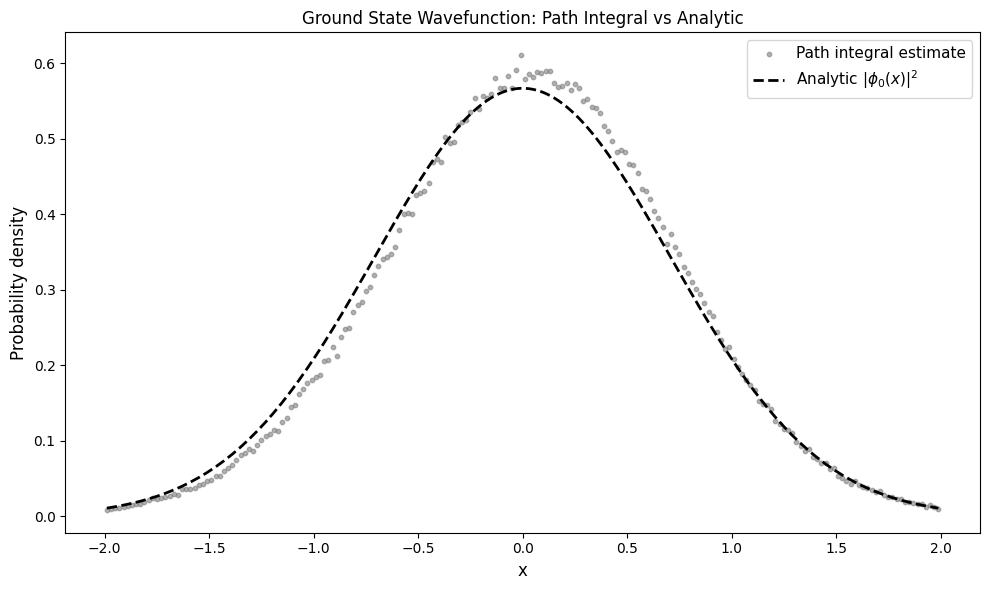

In [28]:
# Initialize paths (Brownian bridge from 0 to 0)
paths_x = np.array([
    Pos_Gen(0.0, 0.0, steps, dt)
    for _ in range(numb_paths)
])

C = 2.5
mid = paths_x.shape[1] // 2
thin = 10
sigma_prop = C * np.sqrt(dt)

# Thermalization
print("Thermalizing...")
for sweep in trange(500, desc="Thermalising", mininterval=0):
    acceptances, endpoint_accept = metropolis_sweep_vectorised(
        paths_x, times, mass, x_potential, sigma_prop
    )

    if sweep % 100 == 0:
        tqdm.write(f"Endpoint acceptance ≈ {endpoint_accept:.3f}")

# Sampling
print("\nSampling...")
samples_x = []

for k in trange(5000, desc="Sampling", mininterval=0):
    acceptances, endpoint_accept = metropolis_sweep_vectorised(
        paths_x, times, mass, x_potential, sigma_prop
    )

    if k % 100 == 0:
        tqdm.write(f"Endpoint acceptance ≈ {endpoint_accept:.3f}")

    if k % thin == 0:
        samples_x.append(paths_x[:, -1].copy())

samples_x = np.concatenate(samples_x)

# Compute PDF
x_bins = np.linspace(-2, 2, 201)
pdf_unnormalised_x, bin_edges_x = np.histogram(samples_x, bins=x_bins)

x_centres = 0.5 * (bin_edges_x[1:] + bin_edges_x[:-1])
dx = np.diff(x_bins)[0]

pdf_x = pdf_unnormalised_x / np.sum(pdf_unnormalised_x * dx)

# Analytic PDF
phi_sq_analytic_x = (1 / np.sqrt(np.pi)) * np.exp(-x_centres ** 2)
phi_sq_analytic_x /= np.sum(phi_sq_analytic_x * dx)

# Statistics
mean_square_x = np.mean(samples_x**2)
rms = np.sqrt(mean_square_x)
std = np.std(samples_x)

print("\n------ Results ------")
print(f"Numerical PDF area: {np.sum(pdf_x * dx):.5f}")
print(f"Analytic PDF area: {np.sum(phi_sq_analytic_x * dx):.5f}")
print(f"Standard deviation: {std:.4f} (expected ≈ 0.707)")
print(f"Root mean square: {rms:.4f} (expected ≈ 0.707)")

# Plot
plt.figure(figsize=(10, 6))
plt.scatter(x_centres, pdf_x, label='Path integral estimate', s=10, alpha=0.6, color = 'grey')
plt.plot(x_centres, phi_sq_analytic_x, 'black',linestyle = '--', linewidth=2, label=r'Analytic $|\phi_0(x)|^2$')
plt.xlabel('x', fontsize=12)
plt.ylabel('Probability density', fontsize=12)
plt.legend(fontsize=11)
plt.title('Ground State Wavefunction: Path Integral vs Analytic')

plt.tight_layout()
plt.show()

# Y-Dimension

Thermalizing...


Thermalising:   0%|          | 0/500 [00:00<?, ?it/s]C:\Users\User\AppData\Local\Temp\ipykernel_7188\1045580232.py:60: RuntimeWarning: overflow encountered in exp
  accept = np.random.rand(len(x_old)) < np.exp(-dS)
Thermalising:  18%|█▊        | 91/500 [00:00<00:00, 458.12it/s]

Endpoint acceptance ≈ 0.370


Thermalising:  39%|███▉      | 197/500 [00:00<00:00, 478.81it/s]

Endpoint acceptance ≈ 0.322


Thermalising:  59%|█████▉    | 295/500 [00:00<00:00, 475.82it/s]

Endpoint acceptance ≈ 0.341


Thermalising:  80%|███████▉  | 398/500 [00:00<00:00, 453.67it/s]

Endpoint acceptance ≈ 0.360


Thermalising:  99%|█████████▉| 496/500 [00:01<00:00, 474.29it/s]

Endpoint acceptance ≈ 0.351


Thermalising: 100%|██████████| 500/500 [00:01<00:00, 470.56it/s]



Sampling...


Sampling:   2%|▏         | 96/5000 [00:00<00:09, 507.12it/s]

Endpoint acceptance ≈ 0.374


Sampling:   4%|▍         | 200/5000 [00:00<00:10, 479.56it/s]

Endpoint acceptance ≈ 0.343


Sampling:   6%|▌         | 299/5000 [00:00<00:09, 476.62it/s]

Endpoint acceptance ≈ 0.364


Sampling:   8%|▊         | 399/5000 [00:00<00:09, 486.58it/s]

Endpoint acceptance ≈ 0.354


Sampling:  10%|▉         | 499/5000 [00:01<00:08, 501.50it/s]

Endpoint acceptance ≈ 0.363


Sampling:  12%|█▏        | 599/5000 [00:01<00:08, 489.98it/s]

Endpoint acceptance ≈ 0.338


Sampling:  14%|█▍        | 700/5000 [00:01<00:08, 502.00it/s]

Endpoint acceptance ≈ 0.347


Sampling:  16%|█▌        | 799/5000 [00:01<00:08, 500.70it/s]

Endpoint acceptance ≈ 0.379


Sampling:  18%|█▊        | 900/5000 [00:01<00:08, 478.32it/s]

Endpoint acceptance ≈ 0.335


Sampling:  20%|█▉        | 999/5000 [00:02<00:08, 494.89it/s]

Endpoint acceptance ≈ 0.367


Sampling:  22%|██▏       | 1099/5000 [00:02<00:08, 480.03it/s]

Endpoint acceptance ≈ 0.355


Sampling:  24%|██▍       | 1198/5000 [00:02<00:07, 481.60it/s]

Endpoint acceptance ≈ 0.351


Sampling:  26%|██▌       | 1296/5000 [00:02<00:07, 465.62it/s]

Endpoint acceptance ≈ 0.332


Sampling:  28%|██▊       | 1396/5000 [00:02<00:07, 472.08it/s]

Endpoint acceptance ≈ 0.372


Sampling:  30%|██▉       | 1496/5000 [00:03<00:07, 483.90it/s]

Endpoint acceptance ≈ 0.358


Sampling:  32%|███▏      | 1595/5000 [00:03<00:07, 468.38it/s]

Endpoint acceptance ≈ 0.365


Sampling:  34%|███▍      | 1695/5000 [00:03<00:07, 468.70it/s]

Endpoint acceptance ≈ 0.364


Sampling:  36%|███▌      | 1795/5000 [00:03<00:06, 467.72it/s]

Endpoint acceptance ≈ 0.334


Sampling:  38%|███▊      | 1894/5000 [00:03<00:06, 460.62it/s]

Endpoint acceptance ≈ 0.334


Sampling:  40%|███▉      | 1995/5000 [00:04<00:06, 474.38it/s]

Endpoint acceptance ≈ 0.334


Sampling:  42%|████▏     | 2094/5000 [00:04<00:06, 478.30it/s]

Endpoint acceptance ≈ 0.355


Sampling:  44%|████▍     | 2195/5000 [00:04<00:05, 471.24it/s]

Endpoint acceptance ≈ 0.349


Sampling:  46%|████▌     | 2294/5000 [00:04<00:05, 476.54it/s]

Endpoint acceptance ≈ 0.357


Sampling:  48%|████▊     | 2395/5000 [00:05<00:05, 461.77it/s]

Endpoint acceptance ≈ 0.373


Sampling:  50%|████▉     | 2495/5000 [00:05<00:05, 486.51it/s]

Endpoint acceptance ≈ 0.382


Sampling:  52%|█████▏    | 2595/5000 [00:05<00:05, 466.35it/s]

Endpoint acceptance ≈ 0.314


Sampling:  54%|█████▍    | 2695/5000 [00:05<00:05, 460.05it/s]

Endpoint acceptance ≈ 0.327


Sampling:  56%|█████▌    | 2791/5000 [00:05<00:04, 443.83it/s]

Endpoint acceptance ≈ 0.338


Sampling:  58%|█████▊    | 2885/5000 [00:06<00:04, 430.82it/s]

Endpoint acceptance ≈ 0.349


Sampling:  60%|█████▉    | 2986/5000 [00:06<00:04, 467.17it/s]

Endpoint acceptance ≈ 0.345


Sampling:  62%|██████▏   | 3093/5000 [00:06<00:04, 459.30it/s]

Endpoint acceptance ≈ 0.374


Sampling:  64%|██████▍   | 3193/5000 [00:06<00:03, 454.17it/s]

Endpoint acceptance ≈ 0.339


Sampling:  66%|██████▌   | 3293/5000 [00:07<00:03, 454.78it/s]

Endpoint acceptance ≈ 0.351


Sampling:  68%|██████▊   | 3394/5000 [00:07<00:03, 461.62it/s]

Endpoint acceptance ≈ 0.349


Sampling:  70%|██████▉   | 3494/5000 [00:07<00:03, 454.42it/s]

Endpoint acceptance ≈ 0.365


Sampling:  72%|███████▏  | 3594/5000 [00:07<00:02, 468.69it/s]

Endpoint acceptance ≈ 0.367


Sampling:  74%|███████▍  | 3694/5000 [00:07<00:02, 454.62it/s]

Endpoint acceptance ≈ 0.371


Sampling:  76%|███████▌  | 3793/5000 [00:08<00:02, 462.54it/s]

Endpoint acceptance ≈ 0.325


Sampling:  78%|███████▊  | 3893/5000 [00:08<00:02, 474.46it/s]

Endpoint acceptance ≈ 0.375


Sampling:  80%|███████▉  | 3995/5000 [00:08<00:02, 469.83it/s]

Endpoint acceptance ≈ 0.350


Sampling:  82%|████████▏ | 4094/5000 [00:08<00:01, 468.82it/s]

Endpoint acceptance ≈ 0.306


Sampling:  84%|████████▍ | 4194/5000 [00:08<00:01, 473.98it/s]

Endpoint acceptance ≈ 0.351


Sampling:  86%|████████▌ | 4293/5000 [00:09<00:01, 465.23it/s]

Endpoint acceptance ≈ 0.356


Sampling:  88%|████████▊ | 4395/5000 [00:09<00:01, 464.28it/s]

Endpoint acceptance ≈ 0.350


Sampling:  90%|████████▉ | 4492/5000 [00:09<00:01, 481.39it/s]

Endpoint acceptance ≈ 0.375


Sampling:  92%|█████████▏| 4594/5000 [00:09<00:00, 461.88it/s]

Endpoint acceptance ≈ 0.340


Sampling:  94%|█████████▍| 4694/5000 [00:10<00:00, 453.97it/s]

Endpoint acceptance ≈ 0.361


Sampling:  96%|█████████▌| 4792/5000 [00:10<00:00, 460.93it/s]

Endpoint acceptance ≈ 0.357


Sampling:  98%|█████████▊| 4895/5000 [00:10<00:00, 466.15it/s]

Endpoint acceptance ≈ 0.335


Sampling: 100%|█████████▉| 4994/5000 [00:10<00:00, 456.96it/s]

Endpoint acceptance ≈ 0.325


Sampling: 100%|██████████| 5000/5000 [00:10<00:00, 466.72it/s]



------ Results ------
Numerical PDF area: 1.00000
Analytic PDF area: 1.00000
Standard deviation: 0.1975 (expected ≈ 0.707)
Root mean square: 0.1975 (expected ≈ 0.707)


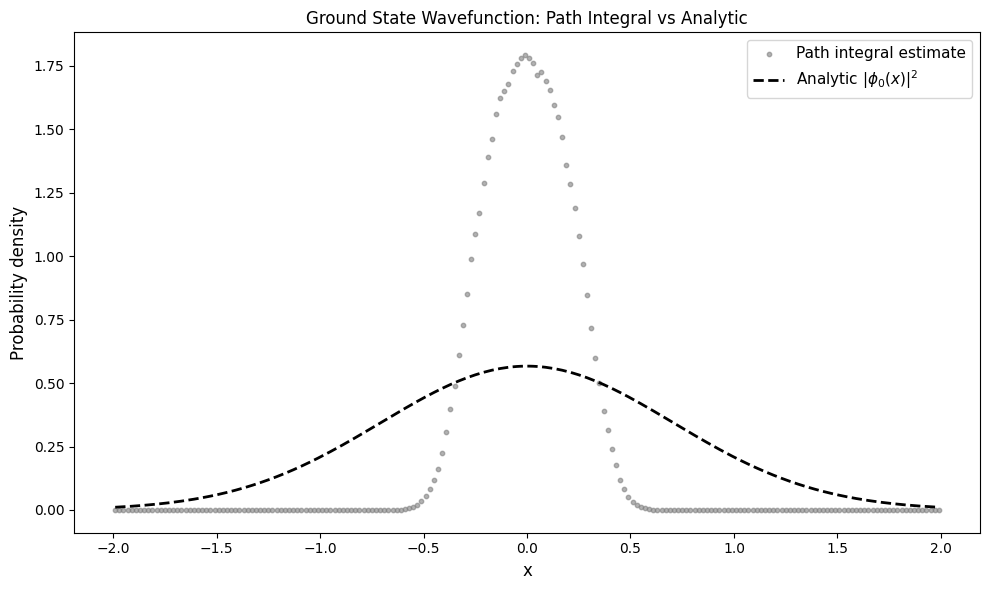

In [27]:
# Initialize paths (Brownian bridge from 0 to 0)
paths_y = np.array([
    Pos_Gen(0.0, 0.0, steps, dt)
    for _ in range(numb_paths)
])

C = 2.5
mid = paths_y.shape[1] // 2
thin = 10
sigma_prop = C * np.sqrt(dt)

# Thermalization
print("Thermalizing...")
for sweep in trange(500, desc="Thermalising", mininterval=0):
    acceptances, endpoint_accept = metropolis_sweep_vectorised(
        paths_y, times, mass, y_potential, sigma_prop
    )

    if sweep % 100 == 0:
        tqdm.write(f"Endpoint acceptance ≈ {endpoint_accept:.3f}")

# Sampling
print("\nSampling...")
samples_y = []

for k in trange(5000, desc="Sampling", mininterval=0):
    acceptances, endpoint_accept = metropolis_sweep_vectorised(
        paths_y, times, mass, y_potential, sigma_prop
    )

    if k % 100 == 0:
        tqdm.write(f"Endpoint acceptance ≈ {endpoint_accept:.3f}")

    if k % thin == 0:
        samples_y.append(paths_y[:, -1].copy())

samples_y = np.concatenate(samples_y)

# Compute PDF
y_bins = np.linspace(-2, 2, 201)
pdf_unnormalised_y, bin_edges_y = np.histogram(samples_y, bins=y_bins)

y_centres = 0.5 * (bin_edges_y[1:] + bin_edges_y[:-1])
dy = np.diff(y_bins)[0]

pdf_y = pdf_unnormalised_y / np.sum(pdf_unnormalised_y * dy)

# Analytic PDF
phi_sq_analytic_y = (1 / np.sqrt(np.pi)) * np.exp(-y_centres ** 2)
phi_sq_analytic_y /= np.sum(phi_sq_analytic_y * dy)

# Statistics
mean_square_y = np.mean(samples_y**2)
rms = np.sqrt(mean_square_y)
std = np.std(samples_y)

print("\n------ Results ------")
print(f"Numerical PDF area: {np.sum(pdf_y * dy):.5f}")
print(f"Analytic PDF area: {np.sum(phi_sq_analytic_y * dy):.5f}")
print(f"Standard deviation: {std:.4f} (expected ≈ 0.707)")
print(f"Root mean square: {rms:.4f} (expected ≈ 0.707)")

# Plot
plt.figure(figsize=(10, 6))
plt.scatter(y_centres, pdf_y, label='Path integral estimate', s=10, alpha=0.6, color = 'grey')
plt.plot(y_centres, phi_sq_analytic_y, 'black',linestyle = '--', linewidth=2, label=r'Analytic $|\phi_0(x)|^2$')
plt.xlabel('x', fontsize=12)
plt.ylabel('Probability density', fontsize=12)
plt.legend(fontsize=11)
plt.title('Ground State Wavefunction: Path Integral vs Analytic')

plt.tight_layout()
plt.show()

In [30]:
print(len(y_bins))
print(len(pdf_y))
print(len(y_centres))
print(len(samples_y))

print(len(x_bins))
print(len(pdf_x))
print(len(x_centres))
print(len(samples_x))

201
200
200
500000
201
200
200
500000


# 3D extension

In [54]:
# =========================
# 3D Joint Probability Density P(x,y)
# =========================
from scipy.ndimage import gaussian_filter

# 2D histogram
bins = np.linspace(-2, 2, 201)  # 100x100 bins
pdf_xy, x_edges, y_edges = np.histogram2d(samples_x, samples_y, bins=[bins, bins])

dx = x_edges[1] - x_edges[0]
dy = y_edges[1] - y_edges[0]

# Normalize so total probability = 1
pdf_xy = pdf_xy / np.sum(pdf_xy * dx * dy)

# Create meshgrid for plotting
x_centres = 0.5 * (x_edges[1:] + x_edges[:-1])
y_centres = 0.5 * (y_edges[1:] + y_edges[:-1])
X, Y = np.meshgrid(x_centres, y_centres)

# Smooth PDF
pdf_xy_smooth = gaussian_filter(pdf_xy, sigma=1)

#extract desired slices
ix0 = np.argmin(np.abs(x_edges[:-1] + dx/2 - 0))  # closest x bin center to 0
iy0 = np.argmin(np.abs(y_edges[:-1] + dy/2 - 0))  # closest y bin center to 0

pdf_xslice = pdf_xy[ix0, :]  # slice along y at x=0
pdf_yslice = pdf_xy[:, iy0]  # slice along x at y=0

pdf_xslice_smooth = pdf_xy_smooth[ix0, :]  # slice along y at x=0
pdf_yslice_smooth = pdf_xy_smooth[:, iy0]  # slice along x at y=0


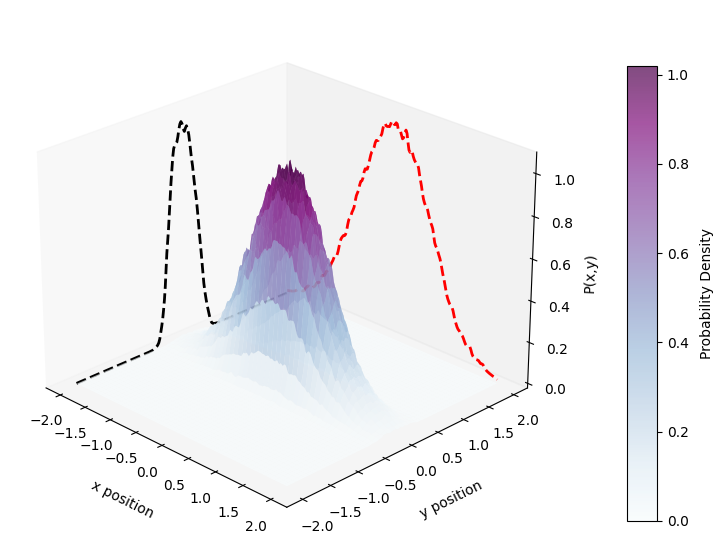

In [108]:
# 3D Plot
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111, projection='3d')

# Smoothed surface
surf = ax.plot_surface(X, Y, pdf_xy_smooth.T, cmap='BuPu', edgecolor='none', alpha = 0.7)

ax.view_init(elev=25, azim=-45)
ax.grid(False)

# Left-hand colorbar
cbar_ax = fig.add_axes([0.86, 0.15, 0.03, 0.65])
cbar = fig.colorbar(surf, cax=cbar_ax, orientation='vertical')
cbar.set_label("Probability Density", labelpad=8)

# Back walls for slice projections
x_wall_back = np.min(x_edges)
y_wall_back = np.max(y_centres)

# Slice along y at x=0
ax.plot(np.full_like(y_centres, x_wall_back), y_centres, pdf_xslice_smooth,
        color='black', linewidth=2, linestyle='--', label='x=0 slice')

# Slice along x at y=0
ax.plot(x_centres, np.full_like(x_centres, y_wall_back), pdf_yslice_smooth,
        color='red', linewidth=2, linestyle='--', label='y=0 slice')

# Labels
ax.set_xlabel('x position', labelpad=10)
ax.set_ylabel('y position', labelpad=10)
ax.set_zlabel('P(x,y)', labelpad=3, rotation=90)
ax.zaxis.label.set_clip_on(False)
ax.zaxis.set_label_coords(1, 0.5, 0)  # manually position z-label
# Adjust layout manually to show z-label


plt.show()
